# Шаг 0. Установка и импорт библиотек

In [60]:
!pip install -q pyspark

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Шаг 1. Инициализация SparkSession

In [61]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, to_timestamp, datediff, when, lit,
    monotonically_increasing_id, min as spark_min,
    max as spark_max, sequence, explode,
    dayofmonth, month, year, date_format, to_date,
    current_date, coalesce
)


spark = SparkSession.builder \
    .appName("jira_dwh") \
    .config("spark.sql.shuffle.partitions", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark успешно инициализирован. Версия:", spark.version)


Spark успешно инициализирован. Версия: 3.5.1


# Шаг 2. Определение путей для слоёв DWH


In [62]:
base_path = "/content/drive/MyDrive/COURSEWORK/dwh"
raw_path = f"{base_path}/raw/jira_issues"
staging_path = f"{base_path}/staging/jira_issues"
core_path = f"{base_path}/core"
marts_path = f"{base_path}/marts"

source_path = "/content/drive/MyDrive/COURSEWORK/GFG_FINAL.csv"

print("RAW:", raw_path)
print("STAGING:", staging_path)
print("CORE:", core_path)
print("MARTS:", marts_path)


RAW: /content/drive/MyDrive/COURSEWORK/dwh/raw/jira_issues
STAGING: /content/drive/MyDrive/COURSEWORK/dwh/staging/jira_issues
CORE: /content/drive/MyDrive/COURSEWORK/dwh/core
MARTS: /content/drive/MyDrive/COURSEWORK/dwh/marts


# Шаг 3. Extract — загрузка исходного CSV


In [63]:
df_raw = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .csv(source_path)

print("Raw count:", df_raw.count())
print("Raw columns (первые 20):", df_raw.columns[:20])

df_raw.write.mode("overwrite").parquet(raw_path)
print("Данные сохранены в raw-слой:", raw_path)


Raw count: 49000
Raw columns (первые 20): ['Summary', 'Issue key', 'Issue id', 'Issue Type', 'Status', 'Project key', 'Project name', 'Project type', 'Project lead', 'Project description', 'Project url', 'Priority', 'Resolution', 'Assignee', 'Reporter', 'Creator', 'Created', 'Updated', 'Last Viewed', 'Resolved']
Данные сохранены в raw-слой: /content/drive/MyDrive/COURSEWORK/dwh/raw/jira_issues


# Шаг 4. Transform — очистка, нормализация и расчёт метрик (staging)

In [64]:
df = spark.read.parquet(raw_path)

# Оставляем только нужные колонки
cols_needed = [
    "Issue key", "Issue id",
    "Summary",
    "Issue Type",
    "Status",
    "Project key", "Project name", "Project type", "Project lead",
    "Reporter",
    "Assignee",
    "Created", "Updated", "Resolved", "Due Date"
]

df = df.select(*[c for c in cols_needed if c in df.columns])

print("Столбцов после отбора:", len(df.columns))
df.printSchema()



Столбцов после отбора: 15
root
 |-- Issue key: string (nullable = true)
 |-- Issue id: string (nullable = true)
 |-- Summary: string (nullable = true)
 |-- Issue Type: string (nullable = true)
 |-- Status: string (nullable = true)
 |-- Project key: string (nullable = true)
 |-- Project name: string (nullable = true)
 |-- Project type: string (nullable = true)
 |-- Project lead: string (nullable = true)
 |-- Reporter: string (nullable = true)
 |-- Assignee: string (nullable = true)
 |-- Created: string (nullable = true)
 |-- Updated: string (nullable = true)
 |-- Resolved: string (nullable = true)
 |-- Due Date: string (nullable = true)



In [65]:
from pyspark.sql.functions import to_timestamp

df = df.withColumn("Created",  to_timestamp(col("Created"),  "dd/MMM/yyyy h:mm a")) \
       .withColumn("Updated",  to_timestamp(col("Updated"),  "dd/MMM/yyyy h:mm a")) \
       .withColumn("Resolved", to_timestamp(col("Resolved"), "dd/MMM/yyyy h:mm a")) \
       .withColumn("Due Date", to_timestamp(col("Due Date"), "dd/MMM/yyyy h:mm a"))


In [66]:
# Признак завершена ли задача
df = df.withColumn(
    "is_completed",
    when(col("Resolved").isNotNull(), lit(1)).otherwise(lit(0))
)

In [67]:
# Расчёт cycle_time_days
df = df.withColumn(
    "cycle_time_days",
    when(
        col("Resolved").isNotNull(),
        datediff(col("Resolved"), col("Created"))
    ).otherwise(lit(None))
)

# Возраст задачи в днях (age_days):
# для закрытых — от Created до Resolved,
# для незакрытых — от Created до текущей даты.
df = df.withColumn(
    "age_days",
    datediff(
        coalesce(col("Resolved"), current_date()),
        col("Created")
    )
)


In [68]:
# Фильтрация явных аномалий по длительности
df = df.filter(
    (col("cycle_time_days").isNull()) |
    ((col("cycle_time_days") >= 0) & (col("cycle_time_days") <= 365))
)

In [69]:
# Удаляем дубликаты по Issue key
rows_before = df.count()
df = df.dropDuplicates(["Issue key"])
rows_after = df.count()

print(f"Staging: {rows_after} строк (удалено дубликатов: {rows_before - rows_after})")


Staging: 944 строк (удалено дубликатов: 45312)


In [70]:
# Сохраняем в staging-слой
df.write.mode("overwrite").parquet(staging_path)
print("Staging сохранён:", staging_path)


Staging сохранён: /content/drive/MyDrive/COURSEWORK/dwh/staging/jira_issues


# Шаг 5. Формирование измерений (core-слой)

In [71]:
df_stg = spark.read.parquet(staging_path)

# dim_project
dim_project = df_stg.select(
    col("Project key").alias("project_key"),
    col("Project name").alias("project_name"),
    col("Project type").alias("project_type"),
    col("Project lead").alias("project_lead")
).dropDuplicates()

dim_project = dim_project.withColumn(
    "project_id",
    monotonically_increasing_id()
)

dim_project.write.mode("overwrite").parquet(f"{core_path}/dim_project")
print("dim_project записан")

dim_project записан


In [72]:
# dim_issue_type
dim_issue_type = df_stg.select(
    col("Issue Type").alias("issue_type_name")
).dropDuplicates()

dim_issue_type = dim_issue_type.withColumn(
    "issue_type_id",
    monotonically_increasing_id()
)

dim_issue_type.write.mode("overwrite").parquet(f"{core_path}/dim_issue_type")
print("dim_issue_type записан")

dim_issue_type записан


In [73]:
# dim_status
dim_status = df_stg.select(
    col("Status").alias("status_name")
).dropDuplicates()

dim_status = dim_status.withColumn("status_category", lit(None).cast("string"))

dim_status = dim_status.withColumn(
    "status_id",
    monotonically_increasing_id()
)

dim_status.write.mode("overwrite").parquet(f"{core_path}/dim_status")
print("dim_status записан")

dim_status записан


In [74]:
# dim_user
dim_user = df_stg.select(
    col("Reporter").alias("user_display_name")
).where(col("user_display_name").isNotNull()).dropDuplicates()

dim_user = dim_user.withColumn(
    "user_id",
    monotonically_increasing_id()
)

dim_user.write.mode("overwrite").parquet(f"{core_path}/dim_user")
print("dim_user записан")


dim_user записан


# Шаг 6. Формирование dim_date на основе диапазона Created

In [75]:
df_stg = spark.read.parquet(staging_path)

minmax_row = df_stg.select(
    spark_min("Created").alias("min_created"),
    spark_max("Created").alias("max_created")
).collect()[0]

date_min = minmax_row["min_created"]
date_max = minmax_row["max_created"]

print("Диапазон дат Created:", date_min, "→", date_max)

Диапазон дат Created: 2019-09-24 13:33:00 → 2023-05-29 06:43:00


In [76]:
# Генерация всех дат в диапазоне
df_dates = spark.range(1).select(
    sequence(
        to_date(lit(date_min)),
        to_date(lit(date_max))
    ).alias("date_seq")
).select(
    explode(col("date_seq")).alias("date")
)

dim_date = df_dates.select(
    col("date").alias("date"),
    dayofmonth("date").alias("day"),
    month("date").alias("month"),
    year("date").alias("year"),
    date_format(col("date"), "E").alias("day_of_week")
).withColumn(
    "date_id", monotonically_increasing_id()
)

dim_date.write.mode("overwrite").parquet(f"{core_path}/dim_date")
print("dim_date записан")
dim_date.show(5, truncate=False)


dim_date записан
+----------+---+-----+----+-----------+----------+
|date      |day|month|year|day_of_week|date_id   |
+----------+---+-----+----+-----------+----------+
|2019-09-24|24 |9    |2019|Tue        |8589934592|
|2019-09-25|25 |9    |2019|Wed        |8589934593|
|2019-09-26|26 |9    |2019|Thu        |8589934594|
|2019-09-27|27 |9    |2019|Fri        |8589934595|
|2019-09-28|28 |9    |2019|Sat        |8589934596|
+----------+---+-----+----+-----------+----------+
only showing top 5 rows



# Шаг 7. Формирование факт-таблицы fact_issues (core-слой)

In [77]:
df_stg = spark.read.parquet(staging_path)

dim_project = spark.read.parquet(f"{core_path}/dim_project")
dim_issue_type = spark.read.parquet(f"{core_path}/dim_issue_type")
dim_status = spark.read.parquet(f"{core_path}/dim_status")
dim_user = spark.read.parquet(f"{core_path}/dim_user")
dim_date = spark.read.parquet(f"{core_path}/dim_date")

In [78]:
# Присоединяем project_id
df_fact = df_stg.join(
    dim_project,
    (df_stg["Project key"] == dim_project["project_key"]) &
    (df_stg["Project name"] == dim_project["project_name"]),
    "left"
)

# Присоединяем issue_type_id
df_fact = df_fact.join(
    dim_issue_type,
    df_fact["Issue Type"] == dim_issue_type["issue_type_name"],
    "left"
)

# Присоединяем status_id
df_fact = df_fact.join(
    dim_status,
    df_fact["Status"] == dim_status["status_name"],
    "left"
)

# Присоединяем reporter_id (user_id)
df_fact = df_fact.join(
    dim_user,
    df_fact["Reporter"] == dim_user["user_display_name"],
    "left"
)

# Присоединяем created_date_id
df_fact = df_fact.join(
    dim_date.withColumnRenamed("date_id", "created_date_id_tmp")
            .withColumnRenamed("date", "created_date_tmp"),
    to_date(df_fact["Created"]) == col("created_date_tmp"),
    "left"
)

df_fact = df_fact.withColumn("created_date_id", col("created_date_id_tmp")) \
                 .drop("created_date_tmp", "created_date_id_tmp")

In [79]:
fact_issues = df_fact.select(
    col("Issue key").alias("issue_key"),
    col("Issue id").alias("issue_id"),
    col("Summary").alias("summary"),
    col("cycle_time_days"),
    col("age_days"),
    col("is_completed"),
    col("project_id"),
    col("issue_type_id"),
    col("status_id"),
    col("user_id").alias("reporter_id"),
    col("Created").alias("created_ts"),
    col("Resolved").alias("resolved_ts"),
    col("created_date_id")
)


fact_issues.write.mode("overwrite").parquet(f"{core_path}/fact_issues")
print("fact_issues записана, строк:", fact_issues.count())
fact_issues.show(5, truncate=False)


fact_issues записана, строк: 944
+----------------+----------------+---------------------------------------------------------------------+---------------+--------+------------+----------+-------------+---------+-----------+-------------------+-------------------+---------------+
|issue_key       |issue_id        |summary                                                              |cycle_time_days|age_days|is_completed|project_id|issue_type_id|status_id|reporter_id|created_ts         |resolved_ts        |created_date_id|
+----------------+----------------+---------------------------------------------------------------------+---------------+--------+------------+----------+-------------+---------+-----------+-------------------+-------------------+---------------+
|""."            |SRCTREEWIN-13651|Unable to merge with GUI when the merge source branch name contains "|NULL           |NULL    |1           |0         |2            |0        |NULL       |NULL               |2023-05-31 07:54

# Шаг 8. Простейшая витрина mart_issue_kpi (marts-слой)

In [80]:
from pyspark.sql.functions import count, avg

In [81]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_issue_type = spark.read.parquet(f"{core_path}/dim_issue_type")
dim_status = spark.read.parquet(f"{core_path}/dim_status")

mart_issue_kpi = fact_issues \
    .join(dim_issue_type, "issue_type_id", "left") \
    .join(dim_status, "status_id", "left") \
    .groupBy("issue_type_name", "status_name") \
    .agg(
        count("issue_key").alias("issues_count"),
        avg("cycle_time_days").alias("avg_cycle_time_days"),
        avg("age_days").alias("avg_age_days")
    )


mart_issue_kpi.write.mode("overwrite").parquet(f"{marts_path}/mart_issue_kpi")
print("mart_issue_kpi сохранён:", f"{marts_path}/mart_issue_kpi")

mart_issue_kpi.show(20, truncate=False)


mart_issue_kpi сохранён: /content/drive/MyDrive/COURSEWORK/dwh/marts/mart_issue_kpi
+---------------+--------------------+------------+-------------------+------------------+
|issue_type_name|status_name         |issues_count|avg_cycle_time_days|avg_age_days      |
+---------------+--------------------+------------+-------------------+------------------+
|Bug            |Short Term Backlog  |14          |NULL               |1188.9285714285713|
|Bug            |Gathering Impact    |11          |NULL               |1144.6363636363637|
|Suggestion     |Under Consideration |1           |NULL               |938.0             |
|Bug            |Needs Triage        |489         |NULL               |1783.3803680981596|
|Suggestion     |Gathering Interest  |127         |NULL               |1676.3070866141732|
|Suggestion     |Future Consideration|1           |NULL               |1337.0            |
|Bug            |In Progress         |3           |NULL               |1162.0            |
|17703

# 9.1. Подготовка вьюх для Spark SQL

In [94]:
from pyspark.sql import functions as F
import seaborn as sns

fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_issue_type = spark.read.parquet(f"{core_path}/dim_issue_type")

dim_status = spark.read.parquet(f"{core_path}/dim_status")
dim_date = spark.read.parquet(f"{core_path}/dim_date")

fact_issues.createOrReplaceTempView("fact_issues")
dim_issue_type.createOrReplaceTempView("dim_issue_type")
dim_status.createOrReplaceTempView("dim_status")
dim_date.createOrReplaceTempView("dim_date")


# 9.2. Распределение задач по типам

In [95]:
issues_by_type = fact_issues \
    .join(dim_issue_type, "issue_type_id", "left") \
    .groupBy("issue_type_name") \
    .count() \
    .orderBy("count", ascending=False)

issues_by_type.show()

+---------------+-----+
|issue_type_name|count|
+---------------+-----+
|            Bug|  803|
|     Suggestion|  140|
|        1770320|    1|
+---------------+-----+



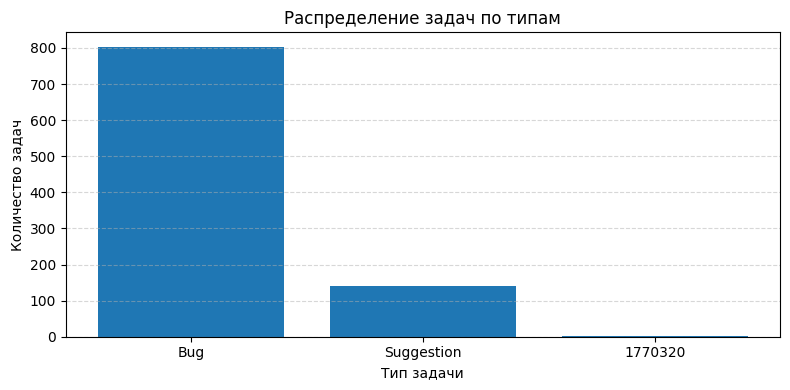

In [96]:
issues_by_type_pd = issues_by_type.toPandas()

plt.figure(figsize=(8, 4))
plt.bar(issues_by_type_pd["issue_type_name"], issues_by_type_pd["count"])
plt.title("Распределение задач по типам")
plt.xlabel("Тип задачи")
plt.ylabel("Количество задач")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Распределение задач по статусам

In [98]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_status = spark.read.parquet(f"{core_path}/dim_status")

issues_by_status = fact_issues \
    .join(dim_status, "status_id", "left") \
    .groupBy("status_name") \
    .count() \
    .orderBy("count", ascending=False)

issues_by_status.show(truncate=False)

+--------------------+-----+
|status_name         |count|
+--------------------+-----+
|Needs Triage        |489  |
|Closed              |282  |
|Gathering Interest  |127  |
|Long Term Backlog   |15   |
|Short Term Backlog  |14   |
|Gathering Impact    |11   |
|In Progress         |3    |
|Bug                 |1    |
|Under Consideration |1    |
|Future Consideration|1    |
+--------------------+-----+



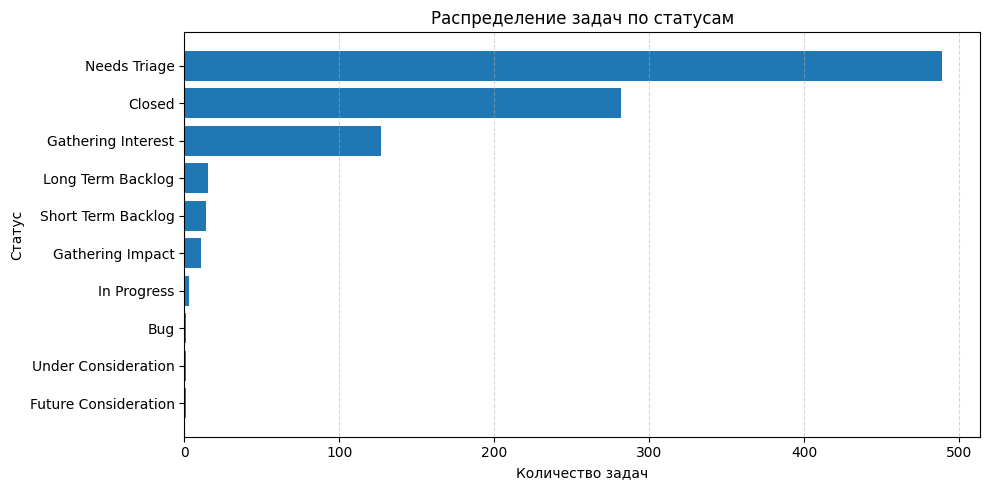

In [99]:
issues_by_status_pd = issues_by_status.toPandas()

plt.figure(figsize=(10, 5))
plt.barh(issues_by_status_pd["status_name"], issues_by_status_pd["count"])
plt.gca().invert_yaxis()
plt.title("Распределение задач по статусам")
plt.xlabel("Количество задач")
plt.ylabel("Статус")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Средняя длительность выполнения задач по типам


In [100]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_issue_type = spark.read.parquet(f"{core_path}/dim_issue_type")
dim_status = spark.read.parquet(f"{core_path}/dim_status")

avg_cycle_by_type = spark.sql("""
    SELECT
        it.issue_type_name,
        ROUND(AVG(fi.cycle_time_days), 2) AS avg_cycle_time_days,
        COUNT(*) AS closed_issues
    FROM fact_issues fi
    JOIN dim_issue_type it ON fi.issue_type_id = it.issue_type_id
    JOIN dim_status st ON fi.status_id = st.status_id
    WHERE fi.is_completed = 1
      AND fi.cycle_time_days IS NOT NULL
    GROUP BY it.issue_type_name
    ORDER BY avg_cycle_time_days
""")

avg_cycle_by_type.show(truncate=False)

+---------------+-------------------+-------------+
|issue_type_name|avg_cycle_time_days|closed_issues|
+---------------+-------------------+-------------+
|Suggestion     |101.73             |11           |
|Bug            |126.49             |271          |
+---------------+-------------------+-------------+



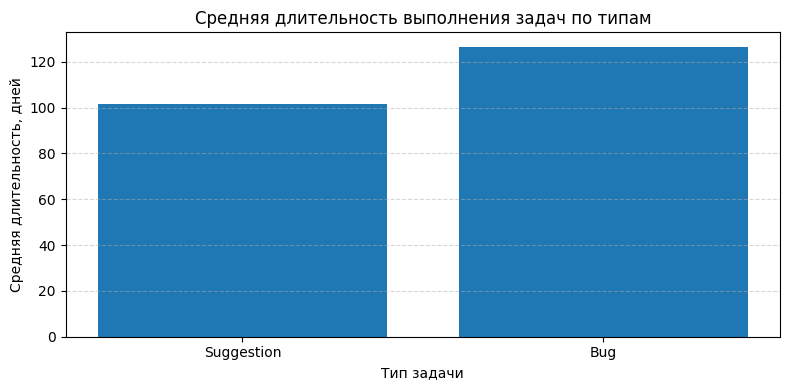

In [102]:
avg_cycle_pd = avg_cycle_by_type.toPandas()

plt.figure(figsize=(8, 4))
plt.bar(avg_cycle_pd["issue_type_name"], avg_cycle_pd["avg_cycle_time_days"])
plt.title("Средняя длительность выполнения задач по типам")
plt.xlabel("Тип задачи")
plt.ylabel("Средняя длительность, дней")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Распределение возраста незавершённых задач

In [103]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")

open_issues_pd = fact_issues \
    .filter((col("is_completed") == 0) & col("age_days").isNotNull()) \
    .select("age_days") \
    .toPandas()

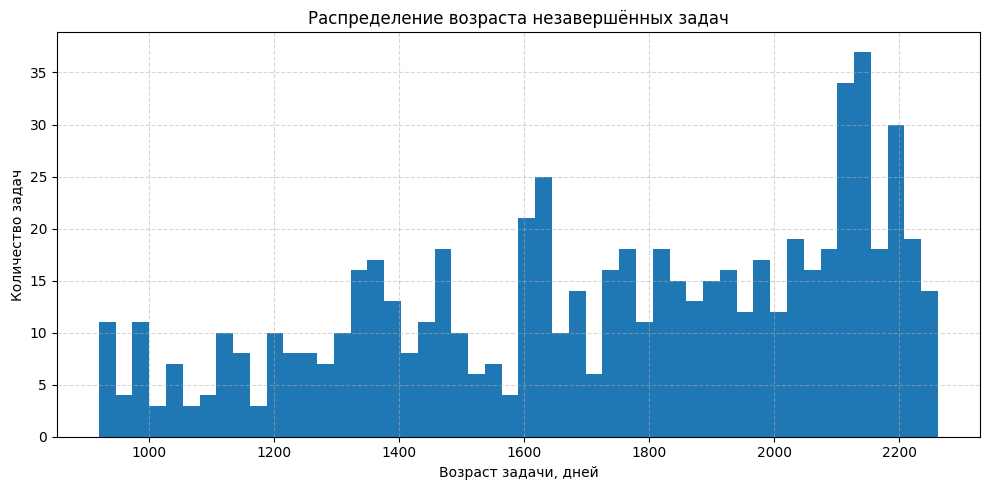

In [104]:
plt.figure(figsize=(10, 5))
plt.hist(open_issues_pd["age_days"], bins=50)
plt.title("Распределение возраста незавершённых задач")
plt.xlabel("Возраст задачи, дней")
plt.ylabel("Количество задач")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Динамика создания задач

In [105]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_date = spark.read.parquet(f"{core_path}/dim_date")

fact_with_date = fact_issues.join(
    dim_date.select("date_id", "year", "month"),
    fact_issues.created_date_id == dim_date.date_id,
    "left"
)

created_by_month = fact_with_date \
    .groupBy("year", "month") \
    .count() \
    .orderBy("year", "month")

created_by_month.show()

+----+-----+-----+
|year|month|count|
+----+-----+-----+
|NULL| NULL|    1|
|2019|    9|    5|
|2019|   10|   19|
|2019|   11|   39|
|2019|   12|   43|
|2020|    1|   90|
|2020|    2|   46|
|2020|    3|   23|
|2020|    4|   22|
|2020|    5|   17|
|2020|    6|   16|
|2020|    7|   24|
|2020|    8|   21|
|2020|    9|   20|
|2020|   10|   20|
|2020|   11|   17|
|2020|   12|   26|
|2021|    1|   26|
|2021|    2|   33|
|2021|    3|   26|
+----+-----+-----+
only showing top 20 rows



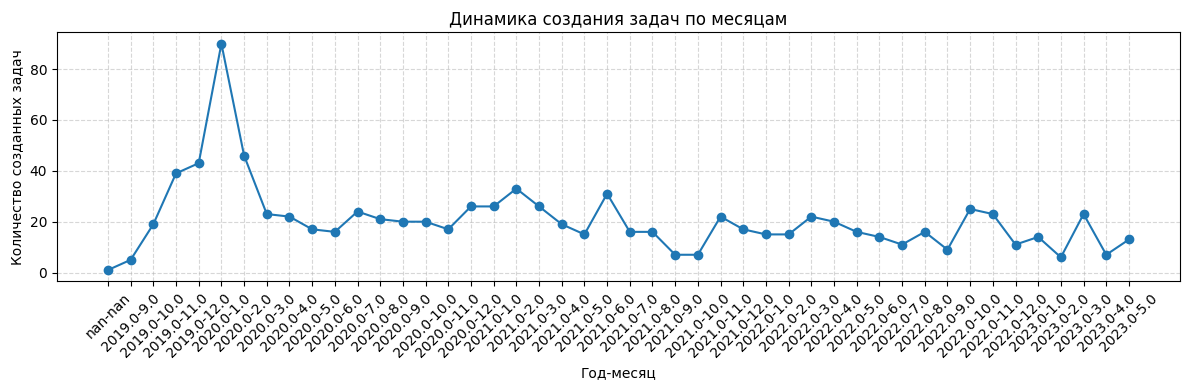

In [106]:
created_by_month_pd = created_by_month.toPandas()
created_by_month_pd["year_month"] = created_by_month_pd["year"].astype(str) + "-" + created_by_month_pd["month"].astype(str)

plt.figure(figsize=(12, 4))
plt.plot(created_by_month_pd["year_month"], created_by_month_pd["count"], marker="o")
plt.title("Динамика создания задач по месяцам")
plt.xlabel("Год-месяц")
plt.ylabel("Количество созданных задач")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


# Heatmap: Issue Type × Status

In [107]:
fact_issues = spark.read.parquet(f"{core_path}/fact_issues")
dim_issue_type = spark.read.parquet(f"{core_path}/dim_issue_type")
dim_status = spark.read.parquet(f"{core_path}/dim_status")

heat_df = fact_issues \
    .join(dim_issue_type, "issue_type_id", "left") \
    .join(dim_status, "status_id", "left") \
    .groupBy("issue_type_name", "status_name") \
    .count()

heat_df.show(truncate=False)

+---------------+--------------------+-----+
|issue_type_name|status_name         |count|
+---------------+--------------------+-----+
|Bug            |Short Term Backlog  |14   |
|Bug            |Gathering Impact    |11   |
|Suggestion     |Under Consideration |1    |
|Bug            |Needs Triage        |489  |
|Suggestion     |Gathering Interest  |127  |
|Suggestion     |Future Consideration|1    |
|Bug            |In Progress         |3    |
|1770320        |Bug                 |1    |
|Bug            |Long Term Backlog   |15   |
|Bug            |Closed              |271  |
|Suggestion     |Closed              |11   |
+---------------+--------------------+-----+



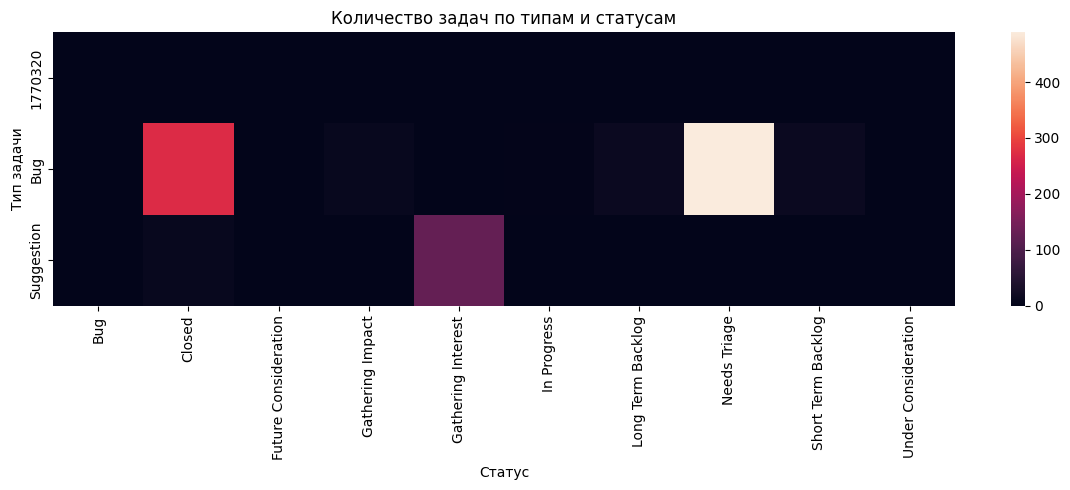

In [108]:
heat_pd = heat_df.toPandas()
pivot = heat_pd.pivot(index="issue_type_name",
                      columns="status_name",
                      values="count").fillna(0)

plt.figure(figsize=(12, 5))
sns.heatmap(pivot, annot=False)
plt.title("Количество задач по типам и статусам")
plt.xlabel("Статус")
plt.ylabel("Тип задачи")
plt.tight_layout()
plt.show()


# Количество закрытых задач по годам

In [87]:
fact_with_date = fact_issues.join(
    dim_date.select("date_id", "year", "month"),
    fact_issues.created_date_id == dim_date.date_id,
    "left"
)

fact_with_date.createOrReplaceTempView("fact_issues_calendar")

closed_by_year = spark.sql("""
    SELECT
        year,
        COUNT(*) AS closed_issues
    FROM fact_issues_calendar
    WHERE is_completed = 1
    GROUP BY year
    ORDER BY year
""")

closed_by_year.show()


+----+-------------+
|year|closed_issues|
+----+-------------+
|NULL|            1|
|2019|           33|
|2020|           91|
|2021|           61|
|2022|           72|
|2023|           25|
+----+-------------+



# Шаг 10. Верификация качества данных и тестирование ETL-процессов

## 10.1. Проверка пропусков в ключевых полях fact_issues

In [88]:
from pyspark.sql.functions import isnan, count, col

fact_issues = spark.read.parquet(f"{core_path}/fact_issues")

# Проверим только важные поля
cols_to_check = [
    "issue_key", "issue_id",
    "project_id", "issue_type_id", "status_id",
    "created_ts", "created_date_id",
    "cycle_time_days", "age_days", "is_completed"
]

exprs = []
for c in cols_to_check:
    dtype = fact_issues.schema[c].dataType.simpleString()
    if dtype in ["double", "float", "int", "bigint"]:
        exprs.append(count(when(col(c).isNull() | isnan(c), c)).alias(c))
    else:
        exprs.append(count(when(col(c).isNull(), c)).alias(c))

null_counts = fact_issues.select(exprs)
print("Количество пропусков по ключевым полям:")
null_counts.show(truncate=False)


Количество пропусков по ключевым полям:
+---------+--------+----------+-------------+---------+----------+---------------+---------------+--------+------------+
|issue_key|issue_id|project_id|issue_type_id|status_id|created_ts|created_date_id|cycle_time_days|age_days|is_completed|
+---------+--------+----------+-------------+---------+----------+---------------+---------------+--------+------------+
|0        |0       |0         |0            |0        |1         |1              |662            |1       |0           |
+---------+--------+----------+-------------+---------+----------+---------------+---------------+--------+------------+



## 10.2. Проверка диапазонов значений для метрик (cycle_time_days, age_days)

In [89]:
fact_issues.select(
    F.min("cycle_time_days").alias("min_cycle_time"),
    F.max("cycle_time_days").alias("max_cycle_time"),
    F.min("age_days").alias("min_age_days"),
    F.max("age_days").alias("max_age_days")
).show()


+--------------+--------------+------------+------------+
|min_cycle_time|max_cycle_time|min_age_days|max_age_days|
+--------------+--------------+------------+------------+
|             0|           361|           0|        2262|
+--------------+--------------+------------+------------+



In [90]:
suspicious_age = fact_issues.filter(
    (col("age_days") < 0) | (col("age_days") > 3650)
)

print("Подозрительно большие/отрицательные age_days:", suspicious_age.count())


Подозрительно большие/отрицательные age_days: 0


## 10.3. Проверка уникальности бизнес-ключа и дубликатов

In [91]:
total_rows = fact_issues.count()
unique_issues = fact_issues.select("issue_key").distinct().count()

print(f"Всего строк в fact_issues: {total_rows}")
print(f"Уникальных issue_key:      {unique_issues}")
print(f"Дубликатов issue_key:      {total_rows - unique_issues}")


Всего строк в fact_issues: 944
Уникальных issue_key:      944
Дубликатов issue_key:      0


## 10.4. Распределения age_days

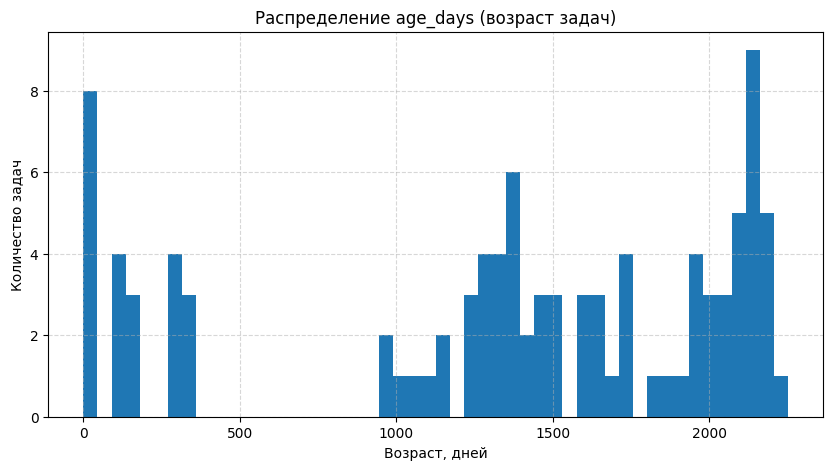

In [92]:
sample_pd = fact_issues.select("age_days") \
    .where(col("age_days").isNotNull()) \
    .sample(False, 0.1, seed=42) \
    .toPandas()

plt.figure(figsize=(10, 5))
plt.hist(sample_pd["age_days"], bins=50)
plt.title("Распределение age_days (возраст задач)")
plt.xlabel("Возраст, дней")
plt.ylabel("Количество задач")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()
